In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from typing import List, Tuple, Dict, Any, Optional

In [3]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime
import numpy as np
import matplotlib.patches as mpatches

In [4]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["figure.titleweight"] = "bold"

In [5]:
step_mapping = {
    'BLOCK_INIT': 0,
    'BLOCK_SCATTER': 1,
    'KERNEL_APPLIED': 2,
    'BLOCK_GATHERED': 3,
    'WRITE_TO_DISK': 4
}

image_size_mapping:Dict[str,Tuple[int,int]] = dict()
with open('metadata.txt') as f:
    for line in f:
        name, width, height = line.split(';')
        image_size_mapping[name] = (int(width), int(height))
        
def get_size_mb(name:str) -> int:
    width, height = image_size_mapping[name]
    return int(width*height*3/10**6)

# Parsing Results


### Parsing of old results

In [5]:
id_map = {}
id_map['197957'] = '32'
id_map['197958'] = '16'
id_map['197960'] = '8'
id_map['197961'] = '4'
id_map['197962'] = '2'
logs_dir = 'out_ssh'
data = []
regex = r"P(\d+): +([A-Z ]+):\s+(\d+\.\d+)\n"
max_date = '2023-01-01'
for log in os.listdir(logs_dir):
    if log.endswith('.txt'):
        run_id = log.split('_')[1].split('.')[0].strip()
        if run_id not in id_map.keys():
            continue
        run_procs = id_map[run_id]
        mod_time = os.stat(logs_dir + '/' + log).st_mtime
        time_as_date = datetime.fromtimestamp(mod_time)
        date = time_as_date.strftime('%Y-%m-%d')
        if date > max_date:
            max_date = date
        with open(logs_dir + '/' + log) as f:
            run_num = 0
            for line in f.readlines():
                if line.startswith('Run '):
                    run_num = int(line.split(' ')[1])
                if line.startswith('P'):
                    match = re.match(regex, line)
                    if match:
                        p = match.group(1)
                        step = match.group(2).replace(' ', '_')
                        time = match.group(3)
                        
                        pkt = {}
                        pkt['job_id'] = run_id
                        pkt['np'] = run_procs
                        pkt['run_num'] = run_num
                        pkt['p'] = p
                        pkt['step'] = step
                        pkt['time'] = round(float(time)*1000,5)
                        data.append(pkt)
df = pd.DataFrame(data)
df.to_csv(f'data_{max_date}.csv', index=False, header=True, quoting=csv.QUOTE_NONNUMERIC, quotechar='"',sep=';')
df.head()

### Parsing of all results

Global id map snap:

```json
{198334: {'NAME': 'pixelate2007_32', 'CPUS': 32},
 198340: {'NAME': 'pixelate0506_32', 'CPUS': 32},
 198333: {'NAME': 'pixelate2007_16', 'CPUS': 16},
 198339: {'NAME': 'pixelate0506_16', 'CPUS': 16},
 198345: {'NAME': 'pixelate0601x8', 'CPUS': 16},
 198344: {'NAME': 'pixelate0601x16', 'CPUS': 16},
 198343: {'NAME': 'pixelate0601x32', 'CPUS': 16},
 198342: {'NAME': 'pixelate0601x64', 'CPUS': 16},
 198341: {'NAME': 'pixelate0601x128', 'CPUS': 16}}
```

In [100]:
global_id_map:Dict[int,Dict[str,str|int]] = pd.read_csv("runs.csv", sep=',',index_col=0).to_dict('index')
indexed_runs_ids:List[str] = [str(a) for a in global_id_map.keys()]
logs_dir:str = 'logs'
data = []
regex = r"P(\d+): +([A-Z ]+):\s+(\d+\.\d+)\n"
max_date = '2023-01-01'
for log in os.listdir(logs_dir):
    if log.endswith('.txt'):
        # e.g. output_197957.txt
        run_id:str= log.split('_')[1].split('.')[0].strip()
        if run_id not in indexed_runs_ids:
            continue
        int_id = int(run_id)

        run_procs:str = str(global_id_map[int_id].get('CPUS'))
        run_name:str = global_id_map[int_id].get('NAME')

        run_info:str = run_name[8:]
        img_code:str ='heic'+ run_info[:4]+'a'
        run_type:str = 'std' if '_' in run_info else 'win'
        window_size:str = run_info[5:] if run_type =='win' else '32'

        mod_time = os.stat(logs_dir + '/' + log).st_mtime
        time_as_date = datetime.fromtimestamp(mod_time)
        date = time_as_date.strftime('%Y-%m-%d')
        if date > max_date:
            max_date = date
        with open(logs_dir + '/' + log) as f:
            run_num = 0
            for line in f.readlines():
                if line.startswith('Run '):
                    run_num = int(line.split(' ')[1])
                if line.startswith('P'):
                    match = re.match(regex, line)
                    if match:
                        p = match.group(1)
                        step = match.group(2).replace(' ', '_')
                        time = match.group(3)
                        
                        pkt = {}
                        pkt['job_id'] = run_id
                        pkt['np'] = run_procs
                        pkt['run_num'] = str(run_num)
                        pkt['p'] = p
                        pkt['step'] = step
                        pkt['window_size'] = window_size
                        pkt['img_code'] = img_code
                        pkt['run_type'] = run_type
                        pkt['time'] = round(float(time)*1000,5)
                        data.append(pkt)
df = pd.DataFrame(data)
df.to_csv(f'data_complete_{max_date}.csv', index=False, header=True, quoting=csv.QUOTE_NONNUMERIC, quotechar='"',sep=';')
df.head()

,job_id,np,run_num,p,step,window_size,img_code,run_type,time
0,197962,2,1,1,BLOCK_INIT,32,heic0601a,std,0.035
1,197962,2,1,0,BLOCK_INIT,32,heic0601a,std,753.442
2,197962,2,1,1,BLOCK_SCATTER,32,heic0601a,std,1460.547
3,197962,2,1,0,BLOCK_SCATTER,32,heic0601a,std,1460.541
4,197962,2,1,0,KERNEL_APPLIED,32,heic0601a,std,6550.132


# Plots and analysis

## Variabilitá step

Elaborazione: ridurre colonne dataframe da complete a (img_code, np, step_n, mean, var)

- **Step 1**. Selezionare solo righe con run_type='std'
- **Step 2**. ~~Selezionare solo righe con step in ('BLOCK_SCATTER','KERNEL_APPLIED','BLOCK_GATHER')~~
- **Step 3**. Ricalcolo tempo con delta rispetto a step precedente (?) tranne per BLOCK_INIT
- **Step 4**. Group by (job_id, step, run_num) e prendere max time
- **Step 4**. Group by (img_code, np, step) o (job_id, step)
- **Step 5**. Calcolo media e varianza time per ogni step
- **Step 6**. Mappatura campi addizionali (e.g. step_n, img_size)

From this figure we can see the variability of the different steps. The most stable step across all runs and datasets is the kernel application step. By far the most variable steps are the steps 0 and 4 which correspond to read/write operations from/to the disk. Other types of operation which yield higher variabily across runs are the communication steps of the algorithm.

/Users/giovanni/miniforge3/envs/benchPD/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


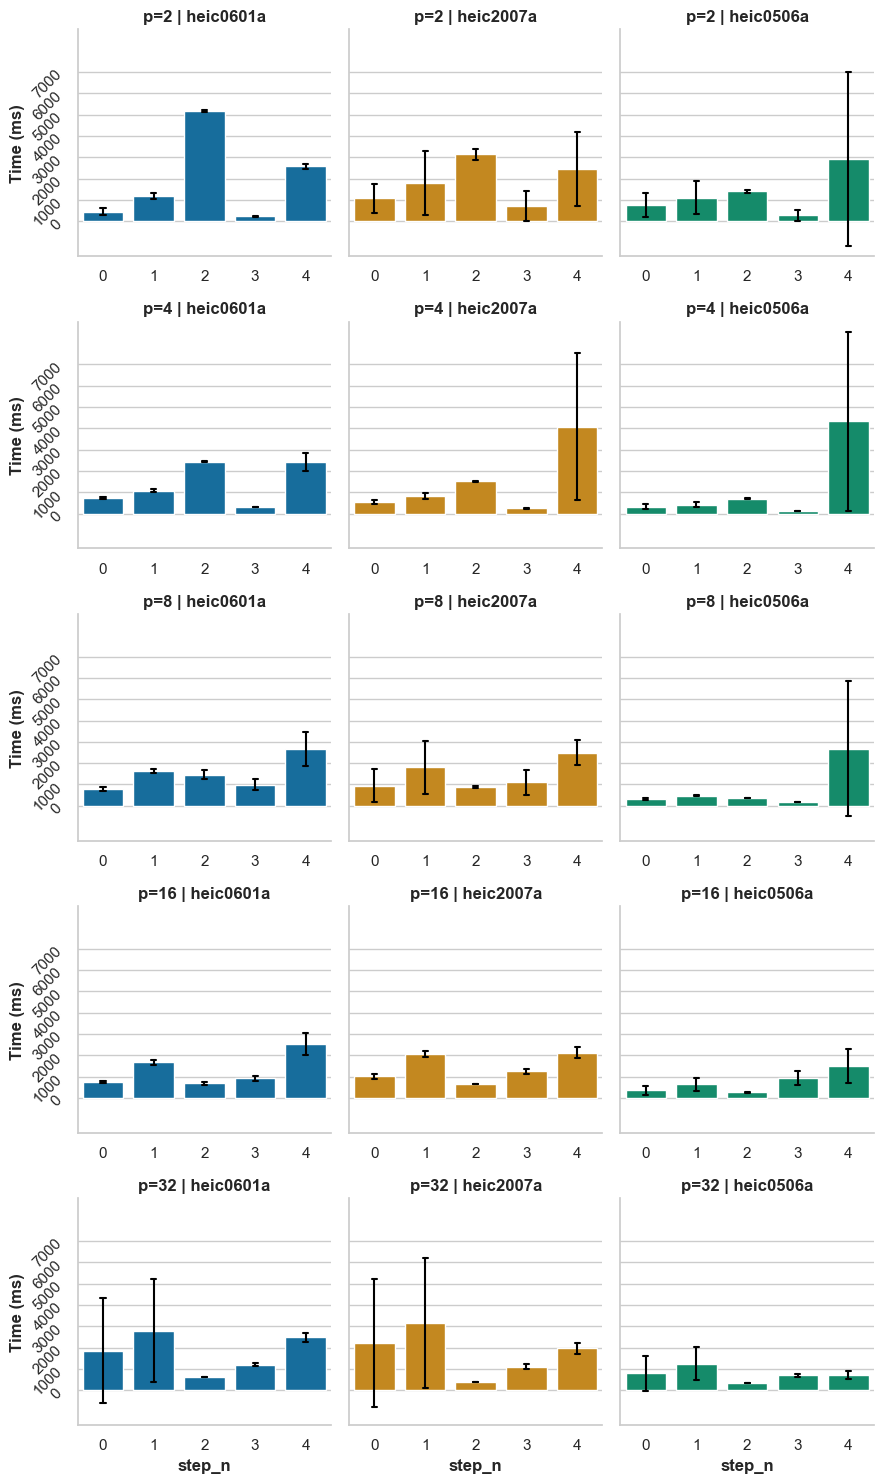

In [84]:
# Read
df = pd.read_csv('data_complete_2023-12-01.csv', sep=';')
# Select standard runs and drop col
df = df[df['run_type']=='std']
df.drop(columns=['run_type','window_size'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Map step names to numbers
df['step_n'] = df['step'].map(step_mapping)

# Calculate time difference between steps and fill blanks
df = df.sort_values(by=['job_id','run_num','p', 'step_n'], ascending=True)

df['time_diff'] = df.groupby(['job_id','run_num','p'],as_index=False)['time'].diff()
df['time_diff'] = df['time_diff'].fillna(df['time'])

# Keep only max time and drop col
df = df.loc[df.groupby(['job_id', 'run_num', 'step_n'])['time_diff'].idxmax()]
df.drop(columns=['p'], inplace=True)

# Plot data
sns.set(style="whitegrid")

g = sns.FacetGrid(df, col="img_code", row="np", palette="colorblind", sharey=True, sharex=False,hue='img_code')
a= g.map(sns.barplot, 'step_n', "time_diff",order=[0,1,2,3,4],  errorbar='sd', errwidth=1.5, capsize=0.1,errcolor='black')
g.set(ylabel='Time (ms)')
g.set_titles(col_template="{col_name}", row_template="p={row_name}")
g.set(yticks=np.linspace(0, 7000, 8))
g.set_yticklabels(np.linspace(0, 7000, 8,dtype=int),rotation=45)
g.savefig('time_diff.png', dpi=400)

## Scalabilitá completamento ultimo step con diff rispetto a iniziale

Elaborazione: ridurre colonne dataframe da complete a (img_code, np, step_n, delta_mean, delta_var, img_size)

- **Step 1**. Selezionare solo righe con run_type='std'
- **Step 2**. Selezionare solo righe con step in 'BLOCK_GATHER'
- **Step 3**. Ricalcolo tempo con delta rispetto a step BLOCK_INIT
- **Step 4**. Group by (job_id, step, run_num) e prendere max time
- **Step 4**. Group by (img_code, np, step) o (job_id, step)
- **Step 5**. Calcolo media e varianza time per ogni step
- **Step 6**. Mappatura campi addizionali (e.g. step_n, img_size)

    index  job_id  np  run_num            step   img_code      time  time_abs  \
3    1237  197957  32        1  BLOCK_GATHERED  heic0601a  8405.281  2118.679   
8    1366  197957  32        2  BLOCK_GATHERED  heic0601a  2910.364  2161.819   
13   1494  197957  32        3  BLOCK_GATHERED  heic0601a  2981.989  2172.902   
18   1624  197957  32        4  BLOCK_GATHERED  heic0601a  3069.695  2323.833   
23   1753  197957  32        5  BLOCK_GATHERED  heic0601a  2900.319  2172.052   

    img_size_mb  
3           972  
8           972  
13          972  
18          972  
23          972  


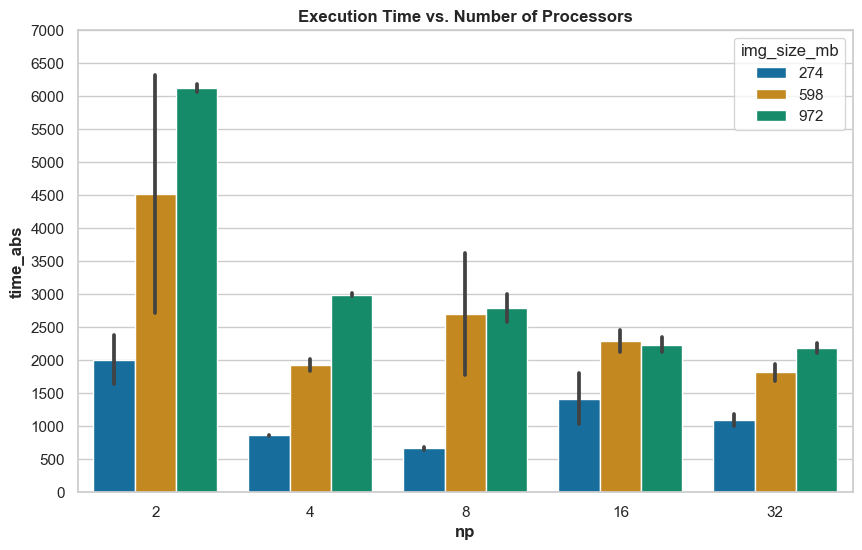

In [98]:
# Read
df = pd.read_csv('data_complete_2023-12-01.csv', sep=';')
# Select standard runs and drop col
df = df[df['run_type']=='std']
df.drop(columns=['run_type','window_size'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Map step names to numbers
df['step_n'] = df['step'].map(step_mapping)
# Keep only max time and drop col
df = df.loc[df.groupby(['job_id', 'run_num', 'step_n'])['time'].idxmax()]
df.drop(columns=['p'], inplace=True)
# Calculate time difference between steps and step 0 and fill blanks
temp_df = df[df['step_n'] == 0][['job_id', 'run_num', 'time']].set_index(['job_id', 'run_num'])
df['time_abs'] = df['time'] - df.set_index(['job_id', 'run_num']).index.map(temp_df['time'])
df.reset_index(inplace=True)
# Calculate time_diff mean and std
df = df[df['step_n'] == 3].drop(columns=['step_n'])
mean_std_df = df
# .groupby(['img_code','np'])['time_abs'].agg(['mean','std']).reset_index()
# Add image size
mean_std_df['img_size_mb'] = mean_std_df['img_code'].apply(get_size_mb)

print(mean_std_df.head())
# Plot data
sns.set(style="whitegrid")
# sns.lineplot(x='np', y='time_abs', hue='img_size_mb', data=mean_std_df, palette='bright',legend='full',errorbar=('ci', 90), err_style='band')
sns.barplot(x='np', y='time_abs', hue='img_size_mb', data=mean_std_df, palette='colorblind',errorbar='sd')
min_points = mean_std_df.loc[mean_std_df.groupby(['np','img_size_mb'])['time_abs'].idxmin()]

# Add a scatter plot to highlight these points
# sns.barplot(x='np', y='time_abs', data=min_points, zorder=2, hue='img_size_mb')
# sns.scatterplot(x='np', y='time_abs', data=min_points, zorder=2, style='img_size_mb')
# plt.xticks(range(2,33,2), labels= [str(a) for a in range(2,33,2)])
plt.yticks(np.linspace(0, 7000, 15))
plt.title('Execution Time vs. Number of Processors')
# plt.savefig('time_abs.png', dpi=400)
plt.show()

In [113]:
aa = mean_std_df[['img_size_mb','np','time_abs']].groupby(['img_size_mb','np']).agg(['mean']).reset_index()
aa.pivot(index='img_size_mb', columns='np').round(3)


time_abs                                        
                 mean                                        
np                 2         4         8         16        32
img_size_mb                                                  
274          2007.868   865.462   664.986  1413.129  1093.073
598          4522.588  1930.230  2702.143  2294.544  1815.264
972          6124.496  2995.777  2794.317  2236.059  2189.857

From this figure we can observe the scalability of the total execution time of the core part of the algorithm (steps 1 to 3). The bigger dataset behaves as we would expect with the total time that decreases with the increasing number of CPUs. The experiments run with the smaller datasets however are not consistent as shown by the standard errors in the plot. In particular, the 274MB dataset achieves the lowest execution time running on 8 CPUs. Increasing the number of CPUs the behaviour has no significant trend but on average we can observe the running time is still higher. The 598MB dataset behaves inconsistently, achieving the lowest running time, both absolute and on average across runs, when run on 32 CPUs. However we cannot observe any considerable trend as, for example, the average running time with 4 CPUs is similar to the running time with 32 CPUs but then it becomes higher with 8 and 16 CPUs.
To better understand the behaviour of the algorithm we will look at how its single steps perform.

## Scalabilitá singoli step dell'algoritmo

Elaborazione: ridurre colonne dataframe da complete a (img_code, np, step_n, delta_mean, delta_var, img_size)

- **Step 1**. Selezionare solo righe con run_type='std'
- **Step 2**. Selezionare solo righe con step in 'BLOCK_GATHER'
- **Step 3**. Ricalcolo tempo con delta rispetto a step BLOCK_INIT
- **Step 4**. Group by (job_id, step, run_num) e prendere max time
- **Step 4**. Group by (img_code, np, step) o (job_id, step)
- **Step 5**. Calcolo media e varianza time per ogni step
- **Step 6**. Mappatura campi addizionali (e.g. step_n, img_size)

/var/folders/m4/xy1ccgjx01l6zksfpb1nvbf00000gn/T/ipykernel_85686/2727985620.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_std_df['img_size_mb'] = mean_std_df['img_code'].apply(get_size_mb)
/Users/giovanni/miniforge3/envs/benchPD/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


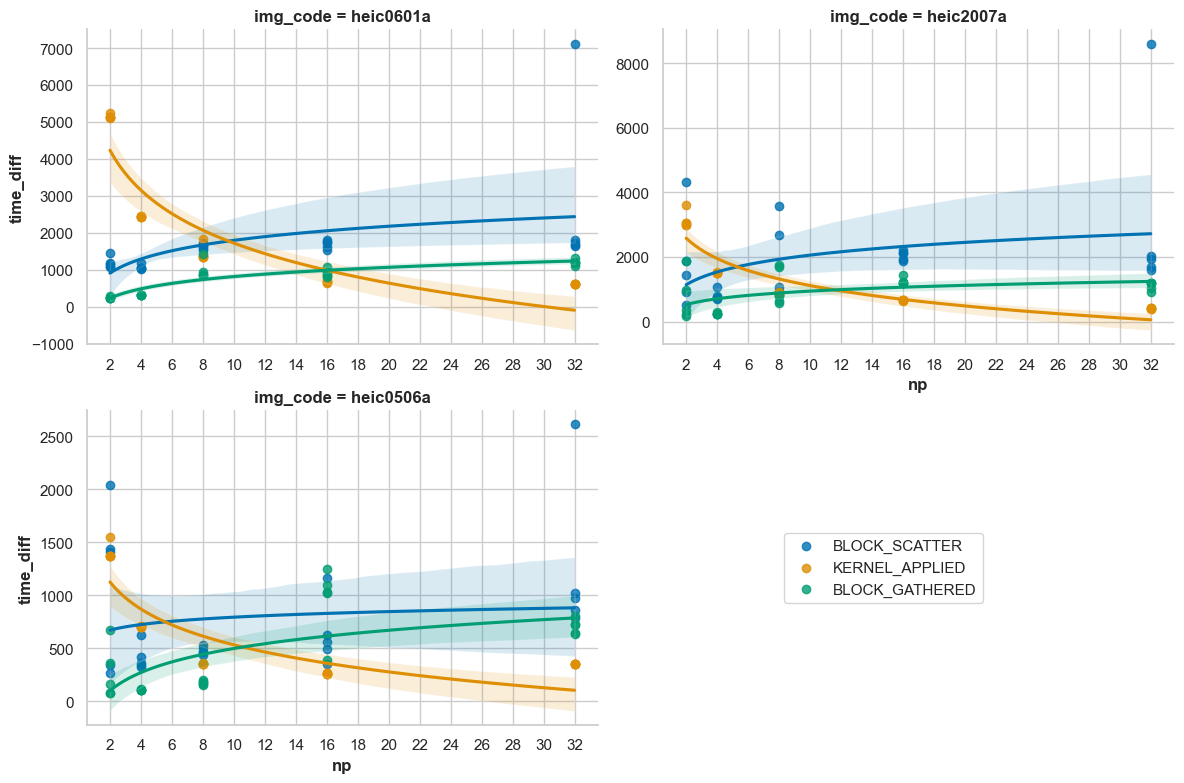

In [114]:
# Read
df = pd.read_csv('data_complete_2023-12-01.csv', sep=';')
# Select standard runs and drop col
df = df[df['run_type']=='std']
df.drop(columns=['run_type','window_size'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Map step names to numbers
df['step_n'] = df['step'].map(step_mapping)

# Calculate time difference between steps and fill blanks
df = df.sort_values(by=['job_id','run_num','p', 'step_n'], ascending=True)

df['time_diff'] = df.groupby(['job_id','run_num','p'],as_index=False)['time'].diff()
df['time_diff'] = df['time_diff'].fillna(df['time'])

# Keep only max time and drop col
df = df.loc[df.groupby(['job_id', 'run_num', 'step_n'])['time_diff'].idxmax()]
df.drop(columns=['p'], inplace=True)
mean_std_df = df[(df['step_n']!=0) & (df['step_n']!=4)]
# Add image size
mean_std_df['img_size_mb'] = mean_std_df['img_code'].apply(get_size_mb)
# Plot data
sns.set(style="whitegrid")

g = sns.FacetGrid(mean_std_df, col="img_code",hue='step', palette='colorblind', col_wrap=2, height=4, aspect=1.5, sharey=False, sharex=False)
g.map(sns.regplot, 'np', 'time_diff',logx=True)
g.set(xticks=range(2,33,2))
# g.add_legend()
plt.legend(loc='center left', bbox_to_anchor=(1.35, 0.5), ncol=1)
g.savefig('time_total.png', dpi=400)

From this figure we can observe how the different steps of the core part of the algorithm behave. In particular, increasing the number of processors speeds up significantly the kernel application step of the algorithm. On the other hand, the time taken by the MPI communication functions MPI_Scatterv and MPI_Gatherv does not get better and seems to remain constant or increase in some cases. From the plot of the image heic0506a, which is the smallest dataset of 274MB, we can also see how these functions are inherently incosistent in their performance. This is particularly evident among the runs with this dataset with 16 processors where the MPI_Gatherv step took on average as much as 4 times the time taken by both the MPI_Scatterv function and the kernel application phase, thus causing the bump we could also see in the preceding figure.

/var/folders/m4/xy1ccgjx01l6zksfpb1nvbf00000gn/T/ipykernel_85686/1685531436.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_std_df['img_size_mb'] = mean_std_df['img_code'].apply(get_size_mb)
/Users/giovanni/miniforge3/envs/benchPD/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


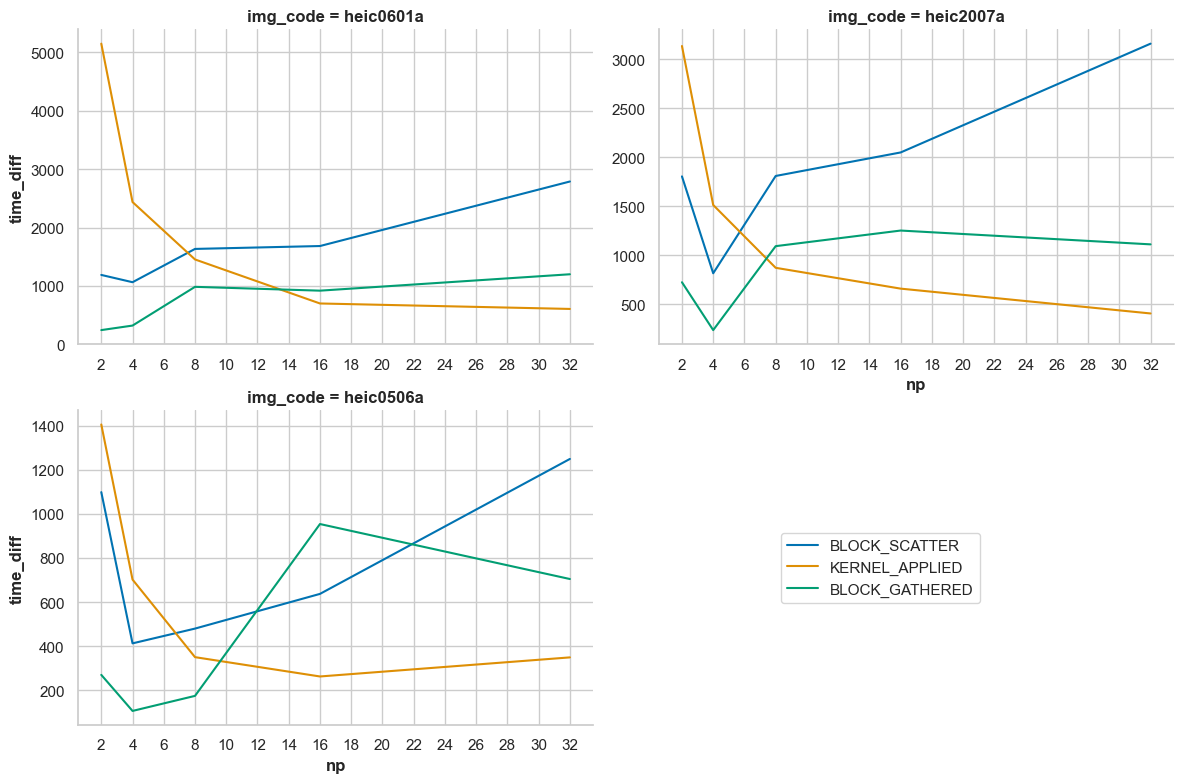

In [97]:
# Read
df = pd.read_csv('data_complete_2023-12-01.csv', sep=';')
# Select standard runs and drop col
df = df[df['run_type']=='std']
df.drop(columns=['run_type','window_size'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Map step names to numbers
df['step_n'] = df['step'].map(step_mapping)

# Calculate time difference between steps and fill blanks
df = df.sort_values(by=['job_id','run_num','p', 'step_n'], ascending=True)

df['time_diff'] = df.groupby(['job_id','run_num','p'],as_index=False)['time'].diff()
df['time_diff'] = df['time_diff'].fillna(df['time'])

# Keep only max time and drop col
df = df.loc[df.groupby(['job_id', 'run_num', 'step_n'])['time_diff'].idxmax()]
df.drop(columns=['p'], inplace=True)
mean_std_df = df[(df['step_n']!=0) & (df['step_n']!=4)]
# Add image size
mean_std_df['img_size_mb'] = mean_std_df['img_code'].apply(get_size_mb)
# Plot data
sns.set(style="whitegrid")

g = sns.FacetGrid(mean_std_df, col="img_code",hue='step', palette='colorblind', col_wrap=2, height=4, aspect=1.5, sharey=False, sharex=False)
g.map(sns.lineplot, 'np', 'time_diff',errorbar=None)
# g.map(sns.regplot, 'np', 'time_diff',logx=True)
g.set(xticks=range(2,33,2))
# g.add_legend()
plt.legend(loc='center left', bbox_to_anchor=(1.35, 0.5), ncol=1)
g.savefig('time_total.png', dpi=400)

## Window size performance scaling

    index  job_id  np  run_num            step  window_size   img_code  \
3     712  198341  16        1  BLOCK_GATHERED          128  heic0601a   
8     778  198341  16        2  BLOCK_GATHERED          128  heic0601a   
13    843  198341  16        3  BLOCK_GATHERED          128  heic0601a   
18    907  198341  16        4  BLOCK_GATHERED          128  heic0601a   
23    973  198341  16        5  BLOCK_GATHERED          128  heic0601a   

         time  time_abs  img_size_mb  
3   24440.227  5675.216          972  
8    3811.510  2688.357          972  
13   4248.545  3176.850          972  
18   6263.029  5453.878          972  
23   5966.036  3370.504          972  


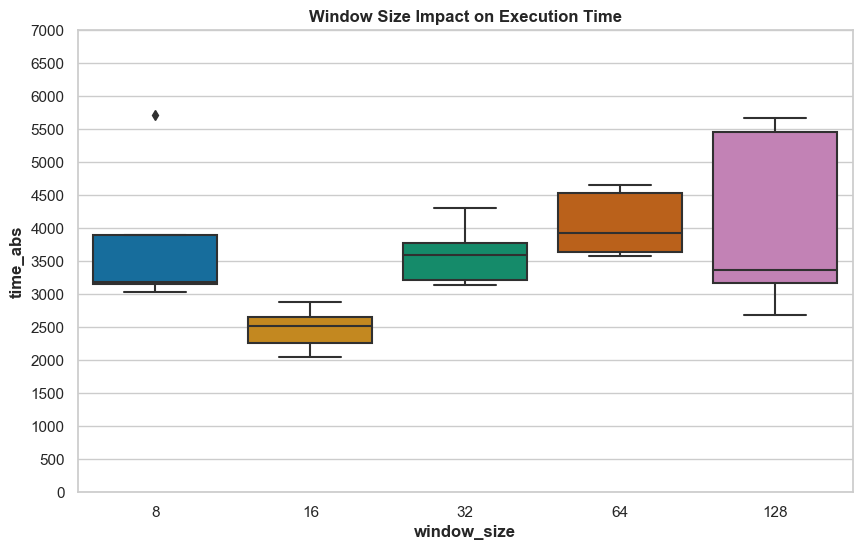

In [88]:
# Read
df = pd.read_csv('data_complete_2023-12-01.csv', sep=';')
# Select standard runs and drop col
df = df[df['run_type']=='win']
df.drop(columns=['run_type'], inplace=True)
df.reset_index(drop=True, inplace=True)
# Map step names to numbers
df['step_n'] = df['step'].map(step_mapping)
# Keep only max time and drop col
df = df.loc[df.groupby(['job_id', 'run_num', 'step_n'])['time'].idxmax()]
df.drop(columns=['p'], inplace=True)
# Calculate time difference between steps and step 0 and fill blanks
temp_df = df[df['step_n'] == 0][['job_id', 'run_num', 'time']].set_index(['job_id', 'run_num'])
df['time_abs'] = df['time'] - df.set_index(['job_id', 'run_num']).index.map(temp_df['time'])
df.reset_index(inplace=True)
# Calculate time_diff mean and std
df = df[df['step_n'] == 3].drop(columns=['step_n'])
mean_std_df = df
# .groupby(['img_code','np'])['time_abs'].agg(['mean','std']).reset_index()
# Add image size
mean_std_df['img_size_mb'] = mean_std_df['img_code'].apply(get_size_mb)

print(mean_std_df.head())
# Plot data
sns.set(style="whitegrid")
# sns.scatterplot(x='window_size', y='time_abs', hue='img_size_mb', data=mean_std_df, palette='bright',legend='full',errorbar=('ci', 90), err_style='band')
sns.boxplot(x='window_size', y='time_abs', data=mean_std_df, palette='colorblind')
# min_points = mean_std_df.loc[mean_std_df.groupby(['window_size'])['time_abs'].idxmin()]
# Add a scatter plot to highlight these points
# sns.scatterplot(x='window_size', y='time_abs', data=min_points, style='img_size_mb')
# plt.xticks(range(8,129,8), labels= [str(a) for a in range(8,129,8)])
plt.yticks(np.linspace(0, 7000, 15))
plt.title('Window Size Impact on Execution Time')
plt.savefig('time_win.png', dpi=400)
plt.show()

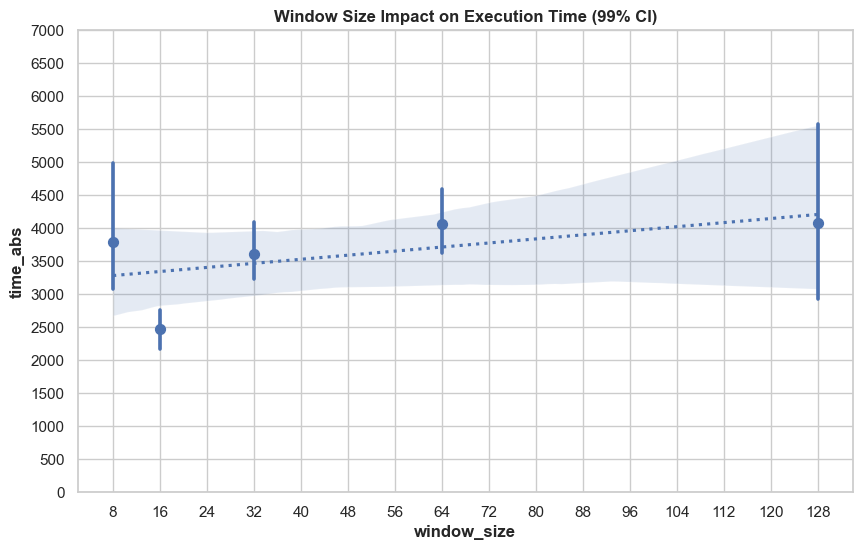

In [154]:
sns.regplot(x='window_size', y='time_abs', data=mean_std_df, ci=99, order=1, line_kws={'linestyle':':'},x_estimator=np.mean)
a =plt.xticks(range(8,129,8), labels= [str(a) for a in range(8,129,8)])
a =plt.title('Window Size Impact on Execution Time (99% CI)')
a = plt.yticks(np.linspace(0, 7000, 15))


From the above plts we can see how the execution time scales with window_size. We can observe that the execution time grows with the window size but the high variability of the results cannot let us infer a significant relationship between these two quantities. This is in line with what we would expect since the window_size parameter influence on the distribution of data is minimal, in particular in the examined case of the 972MB dataset where the image is so big that the biggest window size is still minuscule with respect to the whole image.